In [1]:
import MyLibrary.phantom as ph
import MyLibrary.RayTransform as RT

import numpy as np
import matplotlib.pyplot as plt

# Computerized Tomography

Computerized tomography (CT) became one of the most popular and standard imaging techniques for medical and industrial applications. Its principle  lies on the property of propagation of X-rays, discovered by Wilhelm Röntgen in 1895 at the university of Würzburg, and was developed by Godfrey Hounsfield who won the Nobel Price in 1979 with Allan M. Cormack who studied the inverse problem associated to the so-called Radon transform.


A photon beam, represented by its intensity $I$, flying in a closed domain $\Omega$ with energy $E$ and direction $\vartheta$ satisfies the \textbf{stationary transport equation}
$$
\vartheta \cdot \nabla_\mathbf{x} I(\mathbf{x},\vartheta) + a_E(\mathbf{x}) I(\mathbf{x},\vartheta) = 0, \qquad \mathbf{x} \in \Omega
$$
with $a_E(\mathbf{x})$ called the lineic attenuation coefficient at energy $E$. This coefficient depends on the type of material and represents the \textit{resistance} of the atomic structure to the propagation of the photons. Consider two points S (source) and D (detector) with respective position $s$ and $d$ and note $s-d = r\vartheta$. Solving this ordinary differential equation between S and D leads to the so-called \textbf{Beer-Lambert law} which describes the attenuation of the photon beam between S and D
$$
I(\mathbf{s}+r\vartheta,\vartheta)= I(\mathbf{s},\vartheta) \exp\left(-\int_{0}^{r} a_E\left(\mathbf{s}+ t \vartheta \right) \mathrm{d}t\right).
$$
\vspace{1em}
This relation implies that knowing the intensity at S and measuring the intensity at D gives an information about the integral of the attenuation coefficient under the form 
$$
\ln \frac{I(\mathbf{s},\vartheta)}{I(\mathbf{s}+r\vartheta,\vartheta)} = \int_{0}^{r} a_E\left(\mathbf{s}+ t \vartheta \right) \mathrm{d}t.
$$
Assuming that the object is compactly supported into $\Omega$ and neglecting the attenuation of the air around the object, one gets 
$$
\ln \frac{I(\mathbf{s},\vartheta)}{I(\mathbf{s}+r\vartheta,\vartheta)} = \int_{\mathbb{R}} a_E\left(\mathbf{s}+ t \vartheta \right) \mathrm{d}t
$$
which is simply the integral of the attenuation coefficient along the straight line passing through $s$ with direction $\vartheta$. In two dimensions, this coincides with the X-ray transform or after a suited change of variable with the well-known Radon transform.


## Fanbeam with ring detectors

This geometry can be selected with the attribute <code>modality  = 'fanbeam-ring'</code>. Here the detector set is assumed to be a circle/arc and the center of rotation of the scanner has to coincide with the center of the aforementioned circle.  The source is located arbitrarily on the axis O$y$.

The parameters of the system are therefore $\varphi$, the rotation angle, and $\alpha$ the angle between the detector and the axis O$y$.


To switch back the fanbeam geometry to parallel beams requires the following relationship regarding the detector position:
$$
\alpha = \arcsin\frac{p}{OS} + \arcsin\frac{p}{OD} \quad \text{and} \quad
p = \frac{OS \cdot OD \cdot \sin \alpha}{\sqrt{OS^2+OD^2+2 OS \cdot OD \cdot \cos \alpha}}.
$$

<img src="./Images/CTscan_fanbeam_ring.png" alt="" width="400" height="400"/>


In [2]:
#Parameters of the CT-scan
modality       = 'fanbeam-ring'
N              = 50
Nrota          = 2*N
Ndetector      = 2*N
center         = [N/2,N/2]
distOS         = 1.5*N
distOD         = N/np.sqrt(2)
param_detector = -np.pi/2 + np.pi*np.arange(0,1,1/Ndetector)   
param_rota     = min(param_detector) + (max(param_detector)+np.pi - min(param_detector))*np.arange(0,Nrota)/(Nrota-1) 
parameters     = (param_detector,param_rota,N,center,distOS,distOD)

In [3]:
#Selection of the phantom
f0 = ph.phantom(N)

In [4]:
#Computation of the projection matrix and data
Xring = RT.RayTransform(parameters,modality=modality)     
Xring.computeProjectionMatrix(method='gaussian')
gring = Xring.getData(f0) 

Projection Matrix: [##########]100%  Time elapsed: 1.9 seconds


In [5]:
#Switch to the parallel geometry
p              = -N/2 + N*np.arange(0,1,1/Ndetector)
dp             = p[1] - p[0]
phi            = np.arange(0,Nrota)*np.pi/(Nrota-1) 
gring2para     = Xring.switchfanbeam2parallel(gring,(p,phi))
new_parameters = (p,phi,N,center)
R              = RT.RayTransform(new_parameters,modality = 'parallel')
gRT            = R.RadonTransform(f0)

Fanbeam --> Parallel: [##########]100%  Time elapsed: 0.1 seconds
Line integrals: [##########]100%  Time elapsed: 2.4 seconds


In [6]:
#Computation of the FBP and Approximate inverse
fFBP_ring2para = R.FBP(gring2para)
fAI_ring       = Xring.ApproximateInverseRT(gring,gamma=dp)

FBP: [##########]100%  Time elapsed: 0.0 seconds
ApproxInverse: [##########]100%  Time elapsed: 0.3 seconds


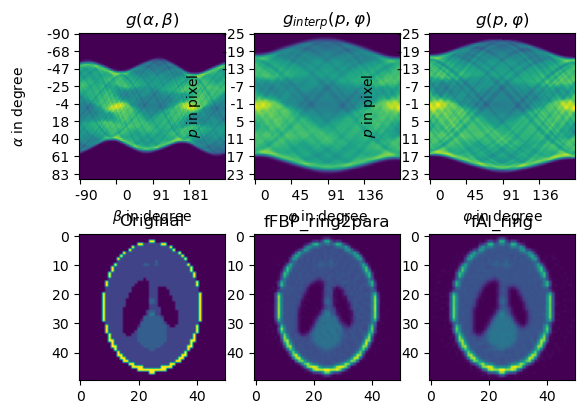

In [7]:
#Visualisation of the data and reconstructions
fig, axs = plt.subplots(2, 3, num=1)
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 10})

xticks = np.arange(0,Nrota,int(Nrota/4))
xticklabels = ["{:6.0f}".format(i) for i in 180/np.pi*param_rota[xticks]]
yticks = np.arange(0,Ndetector,int(Ndetector/8))
yticklabels = ["{:6.0f}".format(i) for i in 180/np.pi*param_detector[yticks]]

axs[0,0].imshow(gring)
axs[0,0].set_xticks(xticks)
axs[0,0].set_xticklabels(xticklabels)
axs[0,0].set_yticks(yticks)
axs[0,0].set_yticklabels(yticklabels)
axs[0,0].set(xlabel=r'$\beta$ in degree', ylabel=r'$\alpha$ in degree',title=r'$g(\alpha,\beta)$')

xticks = np.arange(0,Nrota,int(Nrota/4))
xticklabels = ["{:6.0f}".format(i) for i in 180/np.pi*phi[xticks]]
yticks = np.arange(0,Ndetector,int(Ndetector/8))
yticklabels = ["{:6.0f}".format(i) for i in p[yticks]]

axs[0,1].imshow(gring2para)
axs[0,1].set_xticks(xticks)
axs[0,1].set_xticklabels(xticklabels)
axs[0,1].set_yticks(yticks)
axs[0,1].set_yticklabels(yticklabels)
axs[0,1].set(xlabel=r'$\varphi$ in degree', ylabel=r'$p$ in pixel',title=r'$g_{interp}(p,\varphi)$')

axs[0,2].imshow(gRT)
axs[0,2].set_xticks(xticks)
axs[0,2].set_xticklabels(xticklabels)
axs[0,2].set_yticks(yticks)
axs[0,2].set_yticklabels(yticklabels)
axs[0,2].set(xlabel=r'$\varphi$ in degree', ylabel=r'$p$ in pixel',title=r'$g(p,\varphi)$')



axs[1,0].imshow(f0)
axs[1,0].set_title('Original')
axs[1,1].imshow(fFBP_ring2para)
axs[1,1].set_title('fFBP_ring2para')
axs[1,2].imshow(fAI_ring)
axs[1,2].set_title('fAI_ring')

plt.show()

### Kaczmarz algorithm

Given the projection matrix $R$, we can formulate our inverse problem as solving the linear system of equations $R f = g$. A way to solve this system is to use the Kaczmarz algorithm, also known in imaging applications as the algebraic reconstruction technique (ART). The algorithm runs as follows:
$$ 
f^{k+1}=f^{k}+\lambda _{k}{\frac {g_{i}-\langle r_{i},f^{k}\rangle }{\|r_{i}\|^{2}}}r_{i}^{T}  
$$
where $i=k{\bmod {m}}+1$, $r_{i}$ is the i-th row of the matrix $R$, $g_{i}$ is the i-th component of the vector g. The relaxation parameter $\lambda$ is taken to 1 by default. In the method <code>ART</code>, we implement this approach where $k$ is randomized.

ART: [##########]100%  Time elapsed: 1.5 seconds


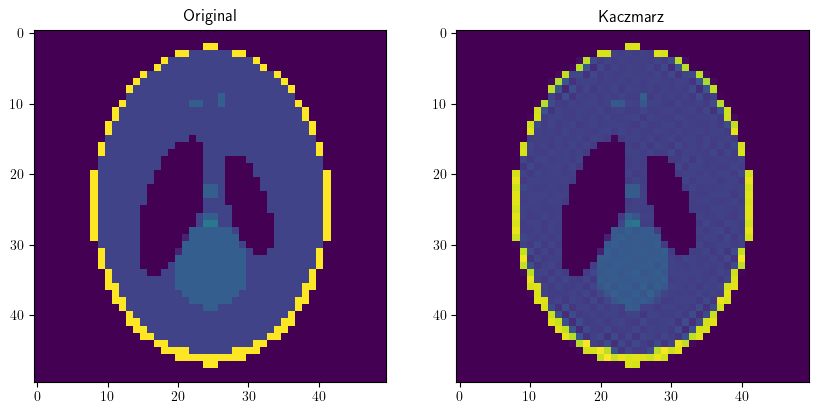

In [8]:
fK = Xring.ART(gring,sweeps=5)
fig, (ax1, ax2) = plt.subplots(1, 2, num=3)
fig.set_size_inches(10,6)
ax1.imshow(f0)
ax1.set_title('Original')
ax2.imshow(fK)
ax2.set_title('Kaczmarz')
plt.show()